# What is Pneumonia?
Pneumonia is an infection that inflames the air sacs (alveoli) in one or both lungs. The air sacs can fill with fluid or pus, causing symptoms such as:
- Cough, which may be dry or produce thick mucus
- Fever, chills, and trouble breathing
- Rapid and shallow breathing, even when resting
- Rapid heartbeat
- Feeling generally unwell
- Sweating and shivering
- Loss of appetite

Pneumonia can be caused by bacteria, viruses, or fungi. Some types of pneumonia are contagious and spread when people cough, sneeze, or talk, sending respiratory droplets into the air. These droplets can then be inhaled by close contacts.
Risk factors include cystic fibrosis, chronic obstructive pulmonary disease (COPD), asthma, diabetes, heart failure, a history of smoking, a poor ability to cough such as following a stroke and a weak immune system.
Pneumonia can be mild and go away on its own within a few weeks. However, it can also be serious enough that you need to get treatment in a hospital.Diagnosis is often based on symptoms and physical examination. Chest X-ray, blood tests, and culture of the sputum may help confirm the diagnosis.The disease may be classified by where it was acquired, such as community- or hospital-acquired or healthcare-associated pneumonia.

In [1]:
%config Completer.use_jedi = False
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from PIL import Image
import seaborn as sns
import cv2
import random
import os
import imageio
import plotly.graph_objects as go
import plotly.express as px
import plotly.figure_factory as ff
from plotly.subplots import make_subplots
from collections import Counter
import glob

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neighbors import LocalOutlierFactor
from sklearn.metrics import accuracy_score, recall_score, precision_score, classification_report, confusion_matrix
from sklearn.model_selection import RandomizedSearchCV, cross_val_score, RepeatedStratifiedKFold
from imblearn.over_sampling import SMOTE

import tensorflow as tf
import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from keras.applications import resnet
from keras.applications.resnet import ResNet50
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau


In [2]:
# If you are running from colab
if 'google.colab' in str(get_ipython()):
    from google.colab import drive
    drive.mount('/content/drive')
    print('Running on CoLab')
    directory = r'/content/drive/My Drive/pneumonia_project/data/original_data/'
else:
    # If you want to run local
    print('Not running on CoLab')
    directory = "D:\Volunteer_DS_2023\Omdena_Myanmar\Pneumonia_detection\Data\original_data"

categories = ['pneumonia', 'normal']

Not running on CoLab


# Common functions

In [3]:
def output_countplot(df, x, order=None, hue=None, figsize=None, title=None):
    '''Output a customized nice looking standardized countplot
        :df: DataFrame to use
        :x: The x axis variable to use in the plot
        :order: The y axis variable to use in the plot default is None
        :hue: The hue variable to use in the plot default is None
        :figsize: The figure size tuple to use in the plot default is None
        :title: The title to use default is Countplot: for {}
    '''

    if (title is None):
        title = 'Countplot for {}'.format(x)

        if (hue is not None):
            title += ' with hue of {}'.format(hue)

    # Use default figsize if not provided
    if (figsize is None):
        figsize=(15,5);

    plt.figure(figsize=figsize);

    plt.xticks(rotation=45);
    plt.rcParams["figure.figsize"] = [7.0, 3.5]
    plt.rcParams["figure.autolayout"] = True

    # Ouput count plot
    ax = sns.countplot(data=df,x=x,order=order,hue=hue);

    # output the amounts on top of the bars
    for p in ax.patches:
        x = p.get_x() + p.get_width() / 2
        y = p.get_y() + p.get_height() + (p.get_height()*0.01)

        value = '{:.1f}'.format(p.get_height())

        if (pd.isna(x) or pd.isna(y) or pd.isna(value)):
            continue

        ax.text(x, y, value, ha="center")

    plt.title(title);
    plt.show();


def output_image_histogram(img, title):
    '''Output image display and associated histogram
        :img:Image to display
        :title: title to output
    '''
    num_columns = 2
    fig, (ax1, ax2) = plt.subplots(1, num_columns)
    fig.suptitle(title)

    ax1.imshow(img)
    ax2.hist(img.ravel(),256,[0,256])

def process_normalize(directory, categories, image_size):
    '''Process and normalize images
        :directory: Root directory of images
        :categories: Categories of diagnosis
        :image_size: Target image size to resize
    '''
    data = []
    X, y = [], []

    for category_index, category in enumerate(categories):
        path = os.path.join(directory, category)

        # Iterate through images and capture image data, resize it and capture category index
        for file in os.listdir(path):
            filepath = os.path.join(path, file)
            img = cv2.imread(filepath, 0)

            # resize the image
            img = cv2.resize(img, (image_size, image_size))
            data.append([img, category_index])

    random.shuffle(data)

    # Split out the image and category data
    image_data, category_data = map(list, zip(*data))
    # Convert the category index into a vector ala [0, 1, 0] because we do
    # not want to imply in the model that index 0 is not as good as 1 and 2 is better than 1 etc.
    y = keras.utils.to_categorical(category_data)

    X = np.array(image_data).reshape(-1, image_size, image_size, 1)

    print('X counts:', X.shape)
    print('y counts:', y.shape)

    # Normalize image values to be between the values of 0 and 1
    X = X / 255.0
    y = np.array(y)

    return X, y

labels = ['pneumonia', 'normal']
def get_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                data.append([img_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [4]:
#Loading Dataset

imgData = get_data(directory)


C:\Users\Nanski\AppData\Local\Temp\ipykernel_48164\4182328443.py:110: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


# Data Analysis

In [5]:
# @title
size_data = []
file_data = []
category_data = []
for category_index, category in enumerate(categories):
    path = os.path.join(directory, category)

    for file in os.listdir(path):
        category_data.append(category)
        filepath = os.path.join(path, file)
        file_data.append(filepath)
        image_shape = imageio.v3.imread(filepath).shape
        height, width = image_shape[0], image_shape[1]
        size_data.append('{} x {}'.format(height, width))


image_meta_df = pd.DataFrame()
image_meta_df['Filename'] = file_data
image_meta_df['Category'] = category_data
image_meta_df['Size'] = size_data
image_meta_df.head()

,Filename,Category,Size
0,D:\Volunteer_DS_2023\Omdena_Myanmar\Pneumonia_...,pneumonia,1024 x 1024
1,D:\Volunteer_DS_2023\Omdena_Myanmar\Pneumonia_...,pneumonia,1024 x 1024
2,D:\Volunteer_DS_2023\Omdena_Myanmar\Pneumonia_...,pneumonia,1024 x 1024
3,D:\Volunteer_DS_2023\Omdena_Myanmar\Pneumonia_...,pneumonia,1024 x 1024
4,D:\Volunteer_DS_2023\Omdena_Myanmar\Pneumonia_...,pneumonia,1024 x 1024


## Visualizing Categories and Image sizes

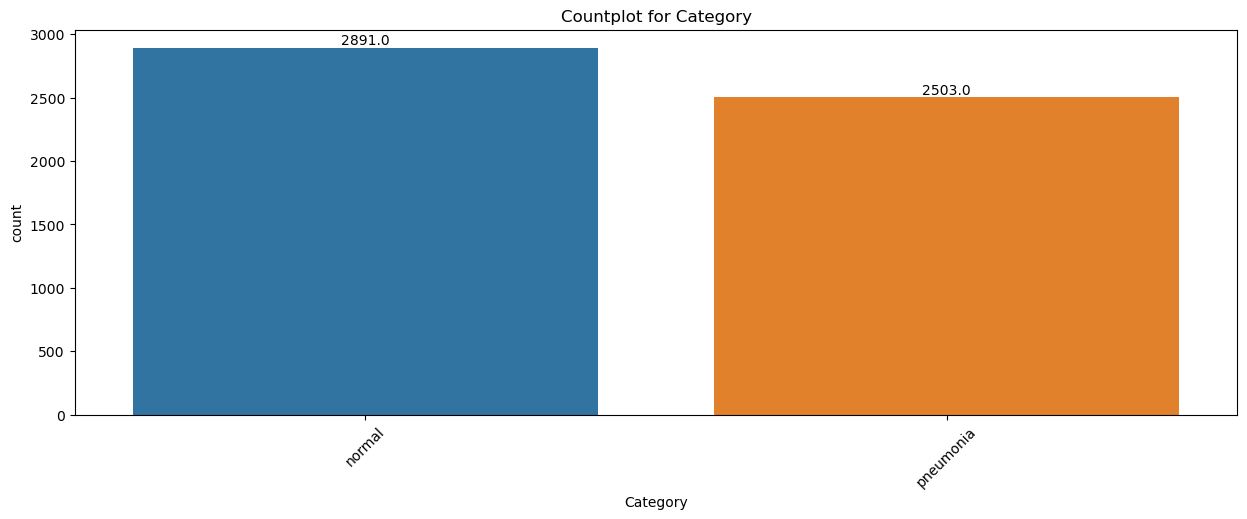

In [6]:
output_countplot(image_meta_df, 'Category', order=image_meta_df['Category'].value_counts().index)

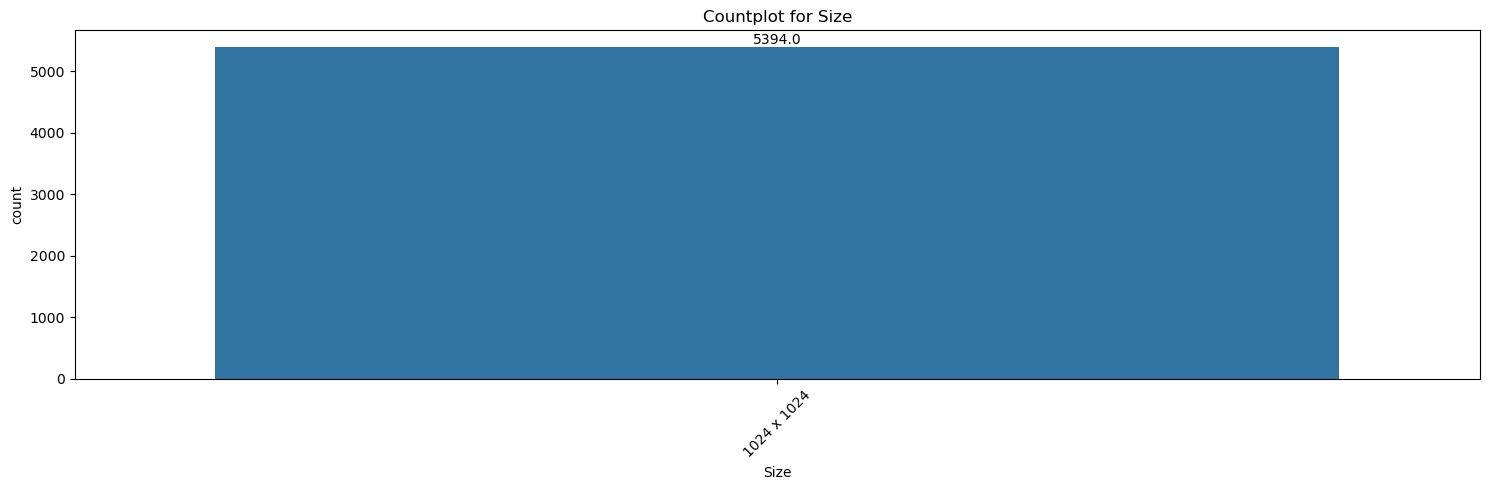

In [7]:
output_countplot(image_meta_df, 'Size', order=image_meta_df['Size'].value_counts().head(30).index)

The complete dataset is of size 1024*1024 and image count is 10000.

# Explore example category images and histograms

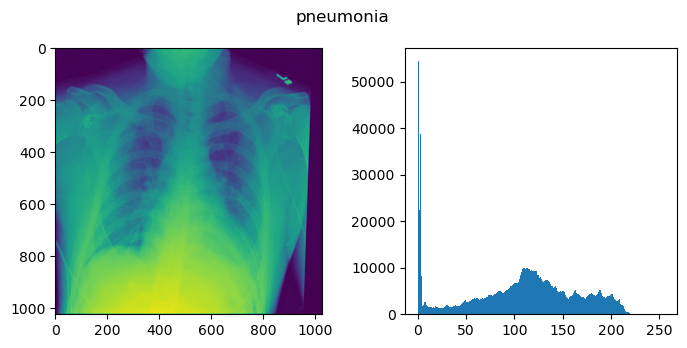

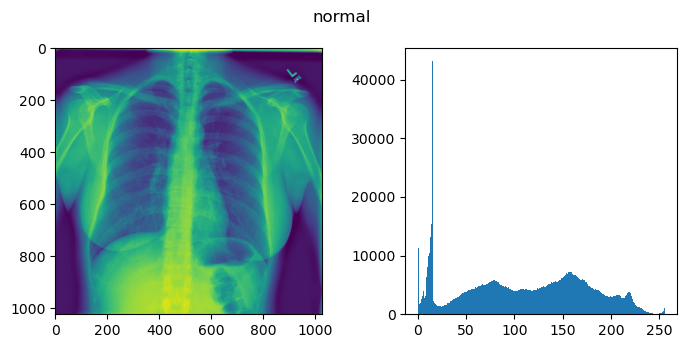

In [8]:
num_columns = 2

for i, category in enumerate(categories):

    path = os.path.join(directory, category)
    file = os.listdir(path)[0]
    filepath = os.path.join(path, file)
    img = cv2.imread(filepath, 0)

    output_image_histogram(img, category)

plt.show()

- In Pneumonia dataset, there are lot of peaks in the histogram. The biggest peak in the number of pixels is at 0 and then there are slightly bigger peaks at 120  and around 160.
- In normal dataset, the pixels are mostly between 50-200 for almost all the images.

Text(0.5, 1.0, 'normal')

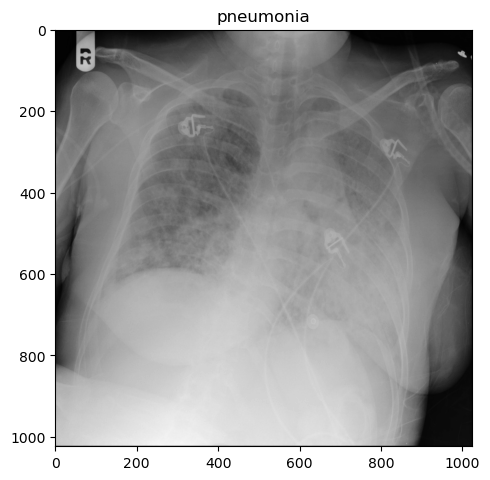

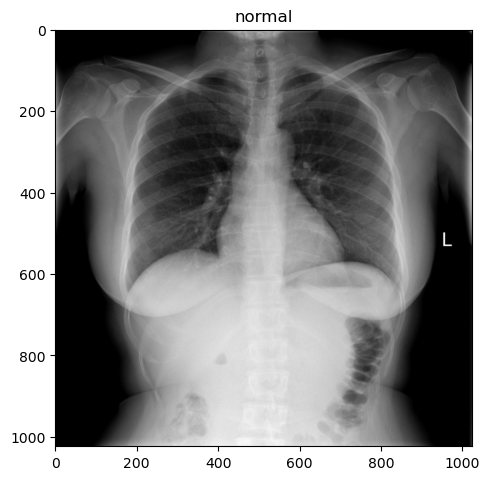

In [9]:
# Previewing the images of both the classes
plt.figure(figsize = (5,5))
plt.imshow(imgData[1][0], cmap='gray')
plt.title(labels[imgData[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(imgData[-2][0], cmap='gray')
plt.title(labels[imgData[-1][1]])

# Preprocess and normalize images and prepare dependent and independent variables

### 256x256 resize and normalization

In [10]:
X_256, Y_256 = process_normalize(directory, categories, 256)

X counts: (5394, 256, 256, 1)
y counts: (5394, 2)


### 512x512 resize and normalization

In [11]:
X_512, Y_512 = process_normalize(directory, categories, 512)

X counts: (5394, 512, 512, 1)
y counts: (5394, 2)


# Preparing Data

## Train, test and split for the 256x256 dataset

In [12]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train256, X_test256, Y_train256, Y_test256 = train_test_split(X_256, Y_256, random_state=42, test_size=1 - train_ratio, stratify=Y_256)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val256, X_test256, Y_val256, Y_test256 = train_test_split(X_test256, Y_test256, random_state=42, test_size=test_ratio/(test_ratio + validation_ratio), stratify=Y_test256)


print('X train length {}, dimensions {}'.format(len(X_train256), X_train256.shape))
print('X test length {}, dimensions {}'.format(len(X_test256), X_test256.shape))
print('X val length {}, dimensions {}'.format(len(X_val256), X_val256.shape))

X train length 4045, dimensions (4045, 256, 256, 1)
X test length 540, dimensions (540, 256, 256, 1)
X val length 809, dimensions (809, 256, 256, 1)


## Train, test and split for the 512x512 dataset

In [13]:
train_ratio = 0.75
validation_ratio = 0.15
test_ratio = 0.10

# train is now 75% of the entire data set
X_train512, X_test512, Y_train512, Y_test512 = train_test_split(X_512, Y_512, random_state=42, test_size=1 - train_ratio, stratify=Y_512)

# test is now 10% of the initial data set
# validation is now 15% of the initial data set
X_val512, X_test512, Y_val512, Y_test512 = train_test_split(X_test512, Y_test512, random_state=42, test_size=test_ratio/(test_ratio + validation_ratio), stratify=Y_test512)


print('X train length {}, dimensions {}'.format(len(X_train512), X_train512.shape))
print('X test length {}, dimensions {}'.format(len(X_test512), X_test512.shape))
print('X val length {}, dimensions {}'.format(len(X_val512), X_val512.shape))

X train length 4045, dimensions (4045, 512, 512, 1)
X test length 540, dimensions (540, 512, 512, 1)
X val length 809, dimensions (809, 512, 512, 1)


### 256*256 dataset
## Data Augmentation

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [15]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train256)

For the data augmentation, i choosed to :

1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

## Training the Model

In [19]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (256,256,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 256, 256, 32)      320       
                                                                 
 batch_normalization_5 (Bat  (None, 256, 256, 32)      128       
 chNormalization)                                                
                                                                 
 max_pooling2d_5 (MaxPoolin  (None, 128, 128, 32)      0         
 g2D)                                                            
                                                                 
 conv2d_6 (Conv2D)           (None, 128, 128, 64)      18496     
                                                                 
 dropout_4 (Dropout)         (None, 128, 128, 64)      0         
                                                                 
 batch_normalization_6 (Bat  (None, 128, 128, 64)     

In [20]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [21]:
history = model.fit(datagen.flow(X_train256, Y_train256, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(X_test256, Y_test256) ,callbacks = [learning_rate_reduction])

Epoch 1/12
127/127 [==============================] - 239s 2s/step - loss: 1.2690 - accuracy: 0.5000 - val_loss: 1.3251 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
127/127 [==============================] - 234s 2s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.7782 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
127/127 [==============================] - ETA: 0s - loss: 0.6932 - accuracy: 0.5000
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
127/127 [==============================] - 239s 2s/step - loss: 0.6932 - accuracy: 0.5000 - val_loss: 0.7001 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
127/127 [==============================] - 233s 2s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 0.6937 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
127/127 [==============================

In [22]:
print("Loss of the model is - " , model.evaluate(X_test256, Y_test256)[0])
print("Accuracy of the model is - " , model.evaluate(X_test256, Y_test256)[1]*100 , "%")

17/17 [==============================] - 5s 314ms/step - loss: 0.6934 - accuracy: 0.5000
Loss of the model is -  0.6934247016906738
17/17 [==============================] - 5s 299ms/step - loss: 0.6934 - accuracy: 0.5000
Accuracy of the model is -  50.0 %


## Analysis after Model Training

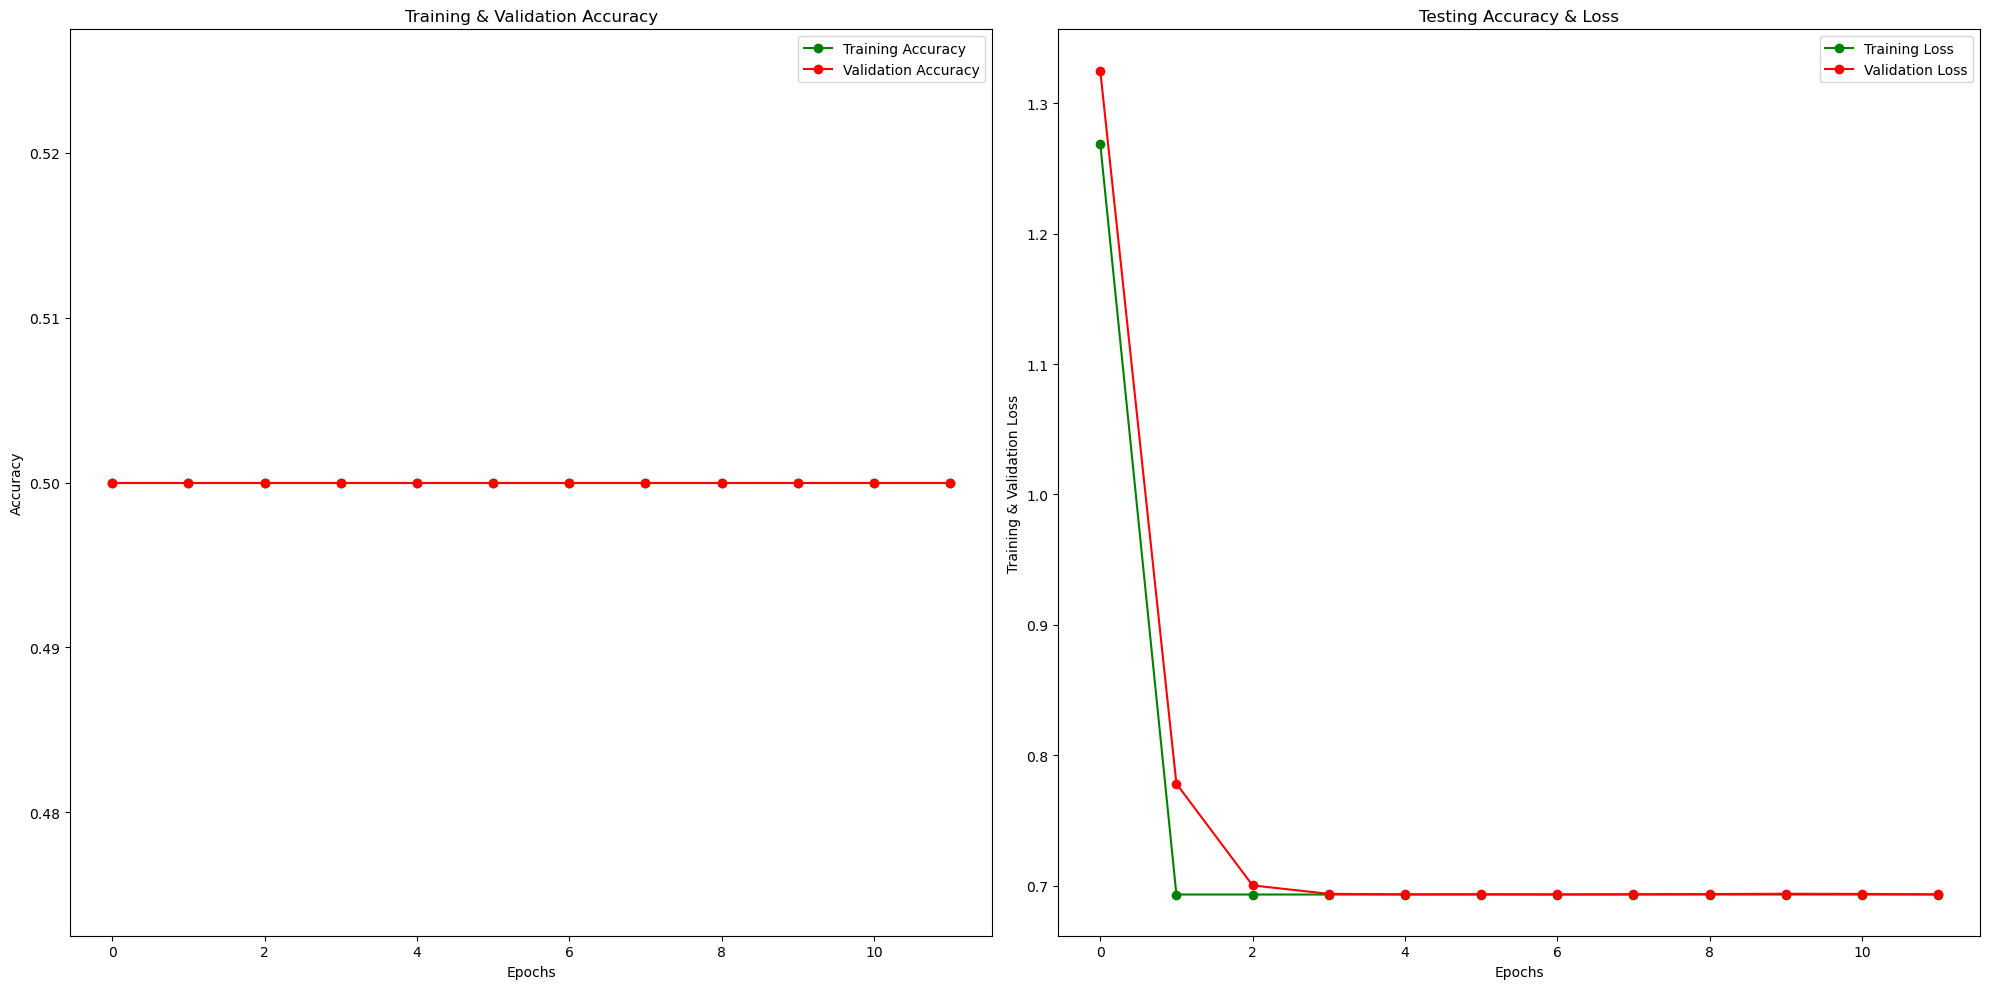

In [23]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [30]:
predictions = model.predict(X_test256)

17/17 [==============================] - 5s 305ms/step


In [41]:
predictions = np.argmax(predictions, axis=1) 
Y_test256 = np.argmax(Y_test256, axis=1)

print(Y_test256.shape, predictions.shape)
print(Y_test256[:5], predictions[:5])

print(classification_report(Y_test256, predictions))


(540,) (540,)
[1 0 1 0 1] [0 0 0 0 0]
              precision    recall  f1-score   support

           0       0.46      1.00      0.63       251
           1       0.00      0.00      0.00       289

    accuracy                           0.46       540
   macro avg       0.23      0.50      0.32       540
weighted avg       0.22      0.46      0.29       540



C:\Users\Nanski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nanski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Nanski\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [42]:
cm = confusion_matrix(Y_test256, predictions)
cm

array([[251,   0],
       [289,   0]], dtype=int64)

In [43]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

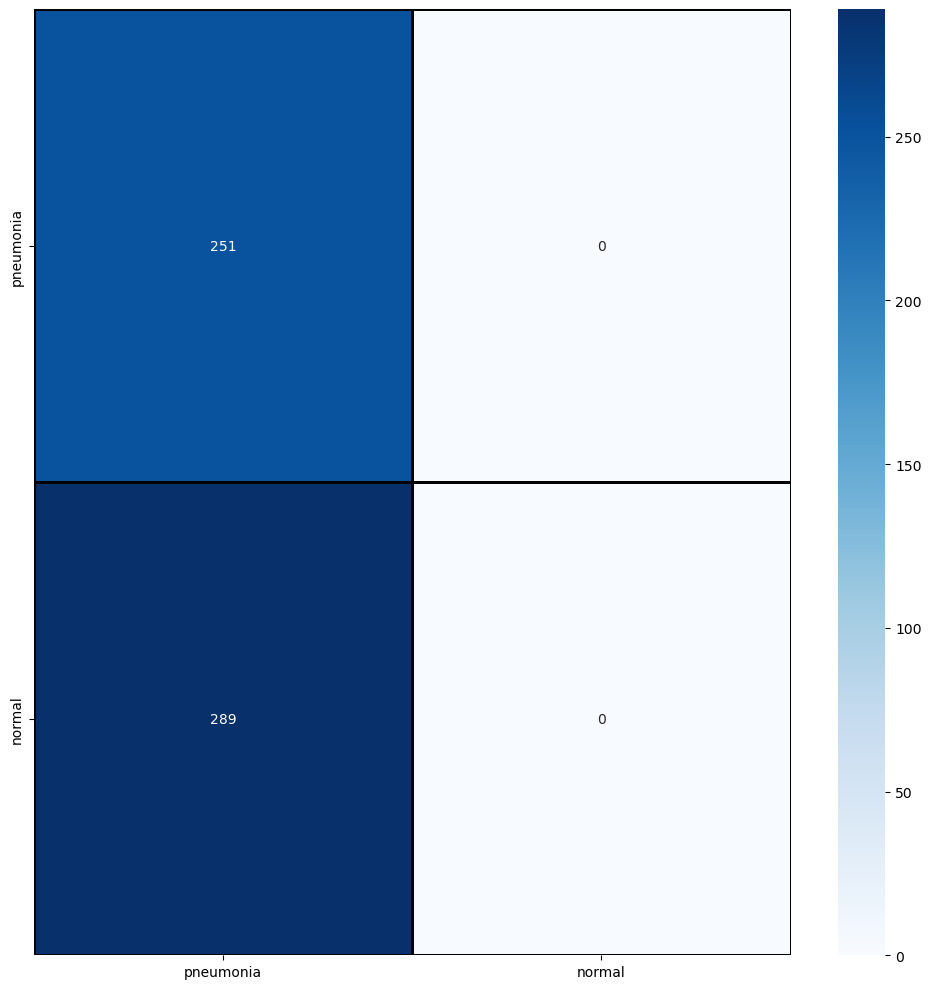

In [44]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [46]:
correct = np.nonzero(predictions == Y_test256)[0]
incorrect = np.nonzero(predictions != Y_test256)[0]

**Some of the Correctly Predicted Classes**

C:\Users\Nanski\AppData\Local\Temp\ipykernel_48164\3700982714.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


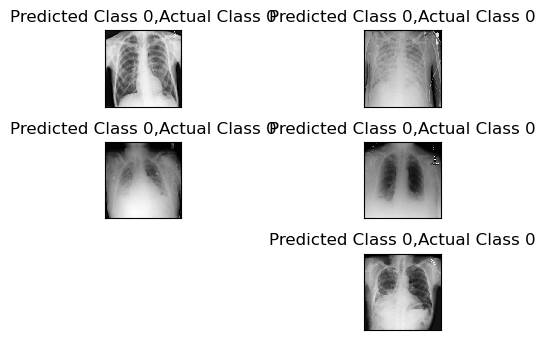

In [47]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test256[c].reshape(256,256), cmap="gray", interpolation='none')
    plt.title("Predicted {},Actual {}".format(predictions[c], Y_test256[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

C:\Users\Nanski\AppData\Local\Temp\ipykernel_48164\1269820912.py:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


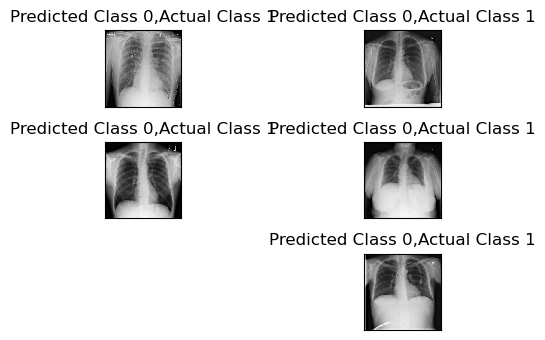

In [48]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test256[c].reshape(256,256), cmap="gray", interpolation='none')
    plt.title("Predicted {},Actual {}".format(predictions[c], Y_test256[c]))
    plt.tight_layout()
    i += 1

### 512*512 dataset
## Data Augmentation

In order to avoid overfitting problem, we need to expand artificially our dataset. We can make your existing dataset even larger. The idea is to alter the training data with small transformations to reproduce the variations. Approaches that alter the training data in ways that change the array representation while keeping the label the same are known as data augmentation techniques. Some popular augmentations people use are grayscales, horizontal flips, vertical flips, random crops, color jitters, translations, rotations, and much more. By applying just a couple of these transformations to our training data, we can easily double or triple the number of training examples and create a very robust model.

In [49]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image 
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = True,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(X_train512)

For the data augmentation, i choosed to :

1. Randomly rotate some training images by 30 degrees
2. Randomly Zoom by 20% some training images
3. Randomly shift images horizontally by 10% of the width
4. Randomly shift images vertically by 10% of the height
5. Randomly flip images horizontally. Once our model is ready, we fit the training dataset.

## Training the Model

In [50]:
model = Sequential()
model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (512,512,1)))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.1))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(Dropout(0.2))
model.add(BatchNormalization())
model.add(MaxPool2D((2,2) , strides = 2 , padding = 'same'))
model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = "rmsprop" , loss = 'binary_crossentropy' , metrics = ['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_10 (Conv2D)          (None, 512, 512, 32)      320       
                                                                 
 batch_normalization_10 (Ba  (None, 512, 512, 32)      128       
 tchNormalization)                                               
                                                                 
 max_pooling2d_10 (MaxPooli  (None, 256, 256, 32)      0         
 ng2D)                                                           
                                                                 
 conv2d_11 (Conv2D)          (None, 256, 256, 64)      18496     
                                                                 
 dropout_8 (Dropout)         (None, 256, 256, 64)      0         
                                                                 
 batch_normalization_11 (Ba  (None, 256, 256, 64)     

In [51]:
learning_rate_reduction = ReduceLROnPlateau(monitor='val_accuracy', patience = 2, verbose=1,factor=0.3, min_lr=0.000001)

In [ ]:
history = model.fit(datagen.flow(X_train512, Y_train512, batch_size = 32) ,epochs = 12 , validation_data = datagen.flow(X_test512, Y_test512) ,callbacks = [learning_rate_reduction])

Epoch 1/12
127/127 [==============================] - 1021s 8s/step - loss: 2.5136 - accuracy: 0.5000 - val_loss: 24.2351 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 2/12
127/127 [==============================] - 2879s 23s/step - loss: 0.6933 - accuracy: 0.5000 - val_loss: 4.9455 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 3/12
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000 
Epoch 3: ReduceLROnPlateau reducing learning rate to 0.0003000000142492354.
127/127 [==============================] - 4432s 35s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 4.5679 - val_accuracy: 0.5000 - lr: 0.0010
Epoch 4/12
127/127 [==============================] - 1045s 8s/step - loss: 0.6931 - accuracy: 0.5000 - val_loss: 2.9204 - val_accuracy: 0.5000 - lr: 3.0000e-04
Epoch 5/12
127/127 [==============================] - ETA: 0s - loss: 0.6931 - accuracy: 0.5000 
Epoch 5: ReduceLROnPlateau reducing learning rate to 9.000000427477062e-05.
127/127 [=====================

In [ ]:
print("Loss of the model is - " , model.evaluate(X_test512, Y_test512)[0])
print("Accuracy of the model is - " , model.evaluate(X_test512, Y_test512)[1]*100 , "%")

## Analysis after Model Training

In [ ]:
epochs = [i for i in range(12)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Testing Accuracy & Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Training & Validation Loss")
plt.show()

In [ ]:
predictions = model.predict(X_test512)


In [ ]:
predictions = np.argmax(predictions, axis=1) 
Y_test512 = np.argmax(Y_test512, axis=1)

print(Y_test512.shape, predictions.shape)
print(Y_test512[:5], predictions[:5])

print(classification_report(Y_test512, predictions))

In [ ]:
cm = confusion_matrix(Y_test512,predictions)
cm

In [ ]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

In [ ]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [ ]:
correct = np.nonzero(predictions == Y_test512)[0]
incorrect = np.nonzero(predictions != Y_test512)[0]

**Some of the Correctly Predicted Classes**

In [ ]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test512[c].reshape(512,512), cmap="gray", interpolation='none')
    plt.title("Predicted {},Actual {}".format(predictions[c], Y_test512[c]))
    plt.tight_layout()
    i += 1

**Some of the Incorrectly Predicted Classes**

In [ ]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(X_test512[c].reshape(512,512), cmap="gray", interpolation='none')
    plt.title("Predicted {},Actual {}".format(predictions[c], Y_test512[c]))
    plt.tight_layout()
    i += 1